In [1]:
import tensorflow as tf
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt

from strawberryfields import ops

from qmlt.tf import CircuitLearner
from qmlt.tf.helpers import make_param

from sklearn.utils import shuffle

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16837048142178522899
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10529338164
locality {
  bus_id: 1
}
incarnation: 8942520084573473692
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


## Prepare data for training

In [3]:
def create_data(samples_per_class: int, intersect_rate: float):
    np.random.seed(0)
    l = samples_per_class
    n = 2
    drop = intersect_rate
    
    sep = int(l * 0.1 * 2)

    X1 = np.array([[-1, -1]]) + drop * np.random.randn(l, n)
    X2 = np.array([[1, 1]]) + drop * np.random.randn(l, n)

    # конкатенируем все в одну матрицу
    # при этом по 20 точек оставим на тест/валидацию
    x, y = np.vstack((X1, X2)), np.hstack([[0] * l, [1] * l])
    x, y = shuffle(x, y, random_state=7)
    
    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    return train_x, train_y, test_x, test_y

## Data and Decision boundary visualization

In [4]:
def visualize_data(arrayX, arrayY, name='dataset') -> None:
    colors = ['blue', 'red', 'yellow', 'green']
    for k in np.unique(arrayY):
        plt.plot(arrayX[arrayY == k, 0], arrayX[arrayY == k, 1], 'o', label='class {}'.format(k), color=colors[k])
    plt.legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
    plt.title(name)
    plt.show()

## Model

In [5]:
class Model:
    def __init__(self, params=None) -> None:
            self.params = [make_param(name='phi'+str(i), regularize=False, constant=.5, monitor=True) for i in range(6)]
            self.squeeze_rate, self.learner = None, None
            self.lr, self.steps = None, None
            if params is not None:
                self.params = params
                
    def myloss(circuit_output, targets):
        return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)


    def outputs_to_predictions(outpt):
        return tf.round(outpt)
    
    def circuit(self, X):
        params = self.params
        
        eng, q = sf.Engine(2)

        with eng:
            ops.Sgate(self.squeeze_rate, X[:, 0]) | q[0]
            ops.Sgate(self.squeeze_rate, X[:, 1]) | q[1]
            ops.BSgate(params[0], params[1]) | (q[0], q[1])
            ops.Rgate(params[2]) | q[0]
            ops.Rgate(params[3]) | q[1]
            ops.Dgate(params[4]) | q[0]
            ops.Dgate(params[5]) | q[1]
            
            
        num_inputs = X.get_shape().as_list()[0]
        state = eng.run('tf', cutoff_dim=2, eval=False, batch_size=num_inputs)

        p0 = state.fock_prob([0, 2])
        p1 = state.fock_prob([2, 0])
        normalization = p0 + p1 + 1e-10
        circuit_output = p1 / normalization

        return circuit_output
    
    def fit(self, lr, sq, steps, train_x, train_y):
        
        self.lr, self.steps, self.squeeze_rate = lr, steps, sq
        
        hyperparams = {'circuit': self.circuit,
                           'task': 'supervised',
                           'loss': self.myloss,
                           'optimizer': 'SGD',
                           'init_learning_rate': lr,
                           'log_every': 1,
                           'warm_start': False
                           }
        
        self.learner = CircuitLearner(hyperparams=hyperparams)
        self.learner.train_circuit(X=train_x, Y=train_y, steps=steps)
        
    def predict(self, test_x, test_y=None, evaluate=True):
        outcomes = self.learner.run_circuit(X=test_x, outputs_to_predictions=self._outputs_to_predictions)
        predictions = outcomes['predictions']
        print('preditions:  {}'.format(predictions))
        if evaluate and test_y is not None:
            test_score = learner.score_circuit(X=test_x, Y=test_y, outputs_to_predictions=outputs_to_predictions)
            print('accuracy on test:  {}'.format(test_score['accuracy']))
            print('loss on test:      {}'.format(test_csore['loss']))
        return predictions
        

## Training

In [6]:
train_x, train_y, test_x, test_y = create_data(100, 0.5)
print(train_x.shape)

(180, 2)


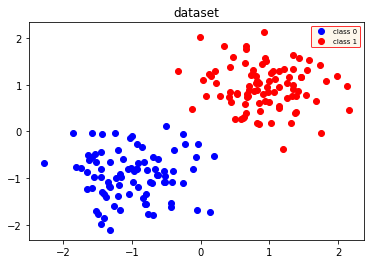

In [7]:
visualize_data(train_x, train_y)

In [8]:
model = Model()
model.fit(lr=0.5, sq=1.5, steps=10, train_x=train_x, train_y=train_y)


----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.0 (default value)
init_learning_rate - 0.5
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - SGD
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True (default value)
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_is_chief': True, '_save_summary_steps': 100, '_task_id': 0, '_service': None, '_model_dir': 'logsAUTO', '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_task_type': 'worker', '_master': '', '_global_id_in_cluster': 0, '_cluster_spec': <tensorflow.python.training.se

ValueError: Tensor("Cast_4:0", shape=(180, 1, 1, 1, 1, 1), dtype=float32) must be from the same graph as Tensor("Beamsplitter/Reshape_3:0", shape=(1, 1, 1, 1, 1, 2), dtype=float32).